# Load Data

### Selected Model Hyper-Paramters

In [8]:
hyperparameters = {'hidden_dim': 128, 'batch_size': 128, 'n1_gat_layers': 1, 'n2_gru_layers': 1, 'num_heads': 4, 'dropout': 0.04033931265087129, 'learning_rate': 0.00015574186652855083, 'pos_lambda': 0.5756532880616873, 'bios_hidden_dim': 32, 'pres_hidden_dim': 64, 'k': 5, 'num_clusters': 240}

### run preprocess pipeline

In [10]:
import preprocess
import imp
imp.reload(preprocess)

data = preprocess.preprocess_pipeline(num_clusters=hyperparameters['num_clusters'])

1. Include only first admissions: N=32513
2. Exclusion by ages: N=25548
3. Include only patients who admitted for at least 24 hours: N=25168
4. Exclude patients who died within 54-hours of admission: N=24556


/home/bnet/kupershmidt/HML/preprocess.py:251: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  pivot = pd.pivot_table(merged, index=['subject_id', 'hadm_id', pd.Grouper(key='charttime', freq=PREDICT_FREQ)],
/home/bnet/kupershmidt/HML/preprocess.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.drop(columns=["mort_30day","prolonged_stay","readmission_30day"], axis=1, inplace=True)
/home/bnet/kupershmidt/HML/preprocess.py:315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val.drop(columns=["mort_30day","prolonged_stay","readmission_30day"], axis=1, inplace=

Pooled embeddings shape: 24529
Number of subjects: 24529


# Datasets creation

In [11]:
import Dataset
import imp
imp.reload(Dataset)
import torch
from torch.utils.data import DataLoader
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
k = hyperparameters['k']

train_labels = torch.tensor(data["y_train"][['mort_30day', 'prolonged_stay', 'readmission_30day']].values, dtype=torch.float32).to(DEVICE)
val_labels = torch.tensor(data["y_val"][['mort_30day', 'prolonged_stay', 'readmission_30day']].values, dtype=torch.float32).to(DEVICE)
test_labels = torch.tensor(data["y_test"][['mort_30day', 'prolonged_stay', 'readmission_30day']].values, dtype=torch.float32).to(DEVICE)


batch_size = hyperparameters['batch_size']
datasets = {x: Dataset.PatientDataset(d, y, core=data["padded_tensor_core"], padding_mask=m, padding_mask_core=data["padding_mask_core"], k=k ,notes=n, bios=b, prescriptions=p) for x, d, y, m, n, b, p in
        zip(['train', 'val', 'test'], [data["padded_tensor_train"], data["padded_tensor_val"], data["padded_tensor_test"]],
            [train_labels, val_labels, test_labels],
            [data["padding_mask_train"], data["padding_mask_val"], data["padding_mask_test"]],
            [data["notes_df_train"].embeddings.values.tolist(),
             data["notes_df_val"].embeddings.values.tolist(),
             data["notes_df_test"].embeddings.values.tolist()],
             [torch.tensor(data["bio_train"].values >= 1, dtype=torch.float32).to(DEVICE),
              torch.tensor(data["bio_val"].values >= 1, dtype=torch.float32).to(DEVICE),
              torch.tensor(data["bio_test"].values >= 1, dtype=torch.float32).to(DEVICE)],
              [torch.tensor(data["prescriptions_train"].values, dtype=torch.float32).to(DEVICE), 
              torch.tensor(data["prescriptions_val"].values, dtype=torch.float32).to(DEVICE), 
              torch.tensor(data["prescriptions_test"].values, dtype=torch.float32).to(DEVICE)])}
dataloaders = {x: DataLoader(datasets[x], batch_size=batch_size, shuffle=True) for x in ['train', 'val', 'test']}

/home/bnet/kupershmidt/HML/Dataset.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.bios = torch.tensor(bios,dtype=torch.float32)
/home/bnet/kupershmidt/HML/Dataset.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.prescriptions =  torch.tensor(prescriptions,dtype=torch.float32)


# Model Training

In [ ]:
import Model 
import imp
imp.reload(Model)
model = Model.GraphGRUMortalityModel(input_dim=data["padded_tensor_train"].shape[2], hidden_dim=hyperparameters['hidden_dim'], 
                                     n1_gat_layers=hyperparameters['n1_gat_layers'], n2_gru_layers=hyperparameters['n2_gru_layers'], 
                                     X_core=data["padded_tensor_core"], num_of_bios=data["bio_train"].shape[1],
                                     num_prescriptions=data["prescriptions_train"].shape[-1], 
                                     bios_hidden_dim=hyperparameters['bios_hidden_dim'], pres_hidden_dim=hyperparameters['pres_hidden_dim'], 
                                     core_padding_mask=data["padding_mask_core"], num_heads=hyperparameters['num_heads'], 
                                     dropout=hyperparameters['dropout'], seq_len=data["padded_tensor_train"].shape[1], k=k, gnn_flag=True).to(DEVICE)
torch.manual_seed(1234)
model.train_all(dataloaders, datasets, epochs=10, learning_rate=hyperparameters['learning_rate'], pos_lambda=hyperparameters['pos_lambda'])
print("Training completed. Validating on test set...")

model.validate(dataloaders['test'], datasets['test'])


### Saving the model and related objects 

In [16]:
import pickle

model.save_model(r"./data/grapth-gru-model.pt")

data_for_inference = {
    "X_core": data["padded_tensor_core"],
    "padding_mask_core": data["padding_mask_core"],
    "scaler": data["scaler"],
    "baseline_df": data["baseline_df"],
    "orgs": data["orgs"],
    "drugs": data["drugs"]
}

with open(r"./data/data.pkl", "wb") as f:
    pickle.dump(data_for_inference, f)

test_subjects = data["X_test"]["subject_id"].drop_duplicates()
y_test = data["y_test"]

test_subjects.to_csv(r"./data/test_subjects.csv")
y_test.to_csv(r"./data/y_test.csv")

Model saved to ./data/grapth-gru-model.pt


## Fairness Anaylsis 

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd
from scipy.stats import spearmanr


res = model.validate(dataloaders['test'], datasets['test'],return_predictions=False)

data = preprocess.preprocess_pipeline(num_clusters=hyperparameters['num_clusters'],scale_meta_features=False)

for_figs = data["X_test"].iloc[:,:8].drop_duplicates()
for_figs["mort_prob"] = res[1][0]
for_figs["prolonged_stay_prob"] = res[1][1]
for_figs["readmission_prob"] = res[1][2]
for_figs["mort_label"] = res[0][0]
for_figs["prolonged_stay_label"] = res[0][1]
for_figs["readmission_label"] = res[0][2]# -------------------------
# Config & soft color palette
# -------------------------
TASKS = [
    ("mort", "mort_label", "mort_prob"),
    ("prolonged_stay", "prolonged_stay_label", "prolonged_stay_prob"),
    ("readmission", "readmission_label", "readmission_prob"),
]
TASK_ORDER = [t[0] for t in TASKS]
COLORS = {
    "mort":           "#8ECAE6",  # light blue
    "prolonged_stay": "#CDB4DB",  # light purple
    "readmission":    "#B7E4C7",  # light green
}

plt.rcParams.update({
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.grid": True,
    "grid.alpha": 0.25,
    "figure.figsize": (22, 5.5),
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
})

# -------------------------
# Prepare ethnicity and gender columns
# -------------------------
eth_cols = [col for col in for_figs.columns if col.startswith("eth_")]
eth_labels = [col.replace("eth_", "") for col in eth_cols]

# 1) AUROC per ethnicity group
auroc_eth = pd.DataFrame(index=eth_labels, columns=TASK_ORDER, dtype=float)
for eth_col, eth_name in zip(eth_cols, eth_labels):
    mask = for_figs[eth_col] == 1
    for t, label_col, prob_col in TASKS:
        if mask.sum() > 0 and for_figs.loc[mask, label_col].nunique() > 1:
            auroc = roc_auc_score(for_figs.loc[mask, label_col], for_figs.loc[mask, prob_col])
        else:
            auroc = np.nan
        auroc_eth.loc[eth_name, t] = auroc

# 2) AUROC per gender
gender_map = {0: "Female", 1: "Male"}
auroc_gender = pd.DataFrame(index=["Female", "Male"], columns=TASK_ORDER, dtype=float)
for g_val, g_name in gender_map.items():
    mask = for_figs["gender"] == g_val
    for t, label_col, prob_col in TASKS:
        if mask.sum() > 0 and for_figs.loc[mask, label_col].nunique() > 1:
            auroc = roc_auc_score(for_figs.loc[mask, label_col], for_figs.loc[mask, prob_col])
        else:
            auroc = np.nan
        auroc_gender.loc[g_name, t] = auroc

# 3) Spearman correlation (probability vs. age)
corrs = {}
for t, _, prob_col in TASKS:
    corr, _ = spearmanr(for_figs["age"], for_figs[prob_col])
    corrs[t] = corr
corr_df = pd.DataFrame({"Task": TASK_ORDER, "Spearman": [corrs[t] for t in TASK_ORDER]})

# -------------------------
# Plot
# -------------------------
fig, axes = plt.subplots(1, 3)

# Ethnicity AUROC (grouped bars)
cols = TASK_ORDER
axes[0].bar(
    x=np.arange(len(auroc_eth.index)) - 0.25,
    height=auroc_eth[cols[0]].values.astype(float),
    width=0.25, label=cols[0].replace("_", " ").title(),
    color=COLORS[cols[0]]
)
axes[0].bar(
    x=np.arange(len(auroc_eth.index)),
    height=auroc_eth[cols[1]].values.astype(float),
    width=0.25, label=cols[1].replace("_", " ").title(),
    color=COLORS[cols[1]]
)
axes[0].bar(
    x=np.arange(len(auroc_eth.index)) + 0.25,
    height=auroc_eth[cols[2]].values.astype(float),
    width=0.25, label=cols[2].replace("_", " ").title(),
    color=COLORS[cols[2]]
)
axes[0].set_xticks(np.arange(len(auroc_eth.index)))
axes[0].set_xticklabels(auroc_eth.index, rotation=30, ha="right")
axes[0].set_title("AUROC by Ethnicity")
axes[0].set_ylabel("AUROC")
axes[0].set_ylim(0.0, 1.0)
axes[0].legend(frameon=False, ncol=1, loc="upper left", bbox_to_anchor=(1.02, 1.0))

# Gender AUROC (grouped bars)
x = np.arange(len(auroc_gender.index))
w = 0.25
for i, t in enumerate(cols):
    axes[1].bar(
        x + (i-1)*w,
        auroc_gender[t].values.astype(float),
        width=w,
        label=t.replace("_", " ").title(),
        color=COLORS[t]
    )
axes[1].set_xticks(x)
axes[1].set_xticklabels(auroc_gender.index)
axes[1].set_title("AUROC by Gender")
axes[1].set_ylabel("AUROC")
axes[1].set_ylim(0.0, 1.0)
axes[1].legend(frameon=False, ncol=1, loc="upper left", bbox_to_anchor=(1.02, 1.0))

# Spearman vs. Age
axes[2].bar(corr_df["Task"].str.replace("_", " ").str.title(),
            corr_df["Spearman"].values,
            color=[COLORS[t] for t in TASK_ORDER])
axes[2].set_title("Correlation of Predicted Risk with Age")
axes[2].set_ylabel("Spearman Correlation")
axes[2].set_xlabel("Task")
axes[2].set_ylim(0, 0.6)

plt.tight_layout()
plt.savefig("fairness_panel.pdf", bbox_inches="tight")


In [15]:
with open(r"./data/data.pkl", "rb") as f:
    data_for_inference = pickle.load(f)

data_for_inference.keys()

dict_keys(['X_train', 'y_train', 'X_core', 'X_val', 'y_val', 'X_test', 'y_test', 'scaler', 'baseline_df', 'orgs', 'drugs', 'y_core', 'selected_subjects', 'notes_df_train', 'notes_df_val', 'notes_df_test', 'padded_tensor_train', 'padding_mask_train', 'padded_tensor_val', 'padding_mask_val', 'padded_tensor_test', 'padding_mask_test', 'padded_tensor_core', 'padding_mask_core', 'bio_train', 'bio_val', 'bio_test', 'prescriptions_train', 'prescriptions_val', 'prescriptions_test'])

### Base Line Model Traning - Same split

In [7]:
import Model 
import imp
imp.reload(Model)
base_model = Model.GraphGRUMortalityModel(input_dim=data["padded_tensor_train"].shape[2], hidden_dim=hyperparameters['hidden_dim'], 
                                     n1_gat_layers=1, n2_gru_layers=1, 
                                     X_core=data["padded_tensor_core"], num_of_bios=data["bio_train"].shape[1],
                                     num_prescriptions=data["prescriptions_train"].shape[-1], 
                                     bios_hidden_dim=hyperparameters['bios_hidden_dim'], pres_hidden_dim=hyperparameters['pres_hidden_dim'], 
                                     core_padding_mask=data["padding_mask_core"], num_heads=hyperparameters['num_heads'], 
                                     dropout=hyperparameters['dropout'], seq_len=data["padded_tensor_train"].shape[1], k=k, gnn_flag=False).to(DEVICE)
torch.manual_seed(1234)
base_model.train_all(dataloaders, datasets, epochs=10, learning_rate=0.001)
print("Training completed. Validating on test set...")



/home/bnet/ronsheinin/anaconda3/envs/scvi/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.04033931265087129 and num_layers=1
  warnings.warn(


Pos weight 0: 7.5728
Pos weight 1: 1.1265
Pos weight 2: 23.5044
Starting epoch 1/10
100%|██████████| 152/152 [01:16<00:00,  1.98it/s]
Epoch 1/10, Loss: 2.9270
100%|██████████| 20/20 [00:10<00:00,  2.00it/s]
Val Mortality - AUC: 0.8247 | AP: 0.4019
Val Prolonged LOS - AUC: 0.7750 | AP: 0.7161
Val Readmission - AUC: 0.6206 | AP: 0.0577
Best model updated
Starting epoch 2/10
100%|██████████| 152/152 [01:16<00:00,  1.99it/s]
Epoch 2/10, Loss: 2.6634
100%|██████████| 20/20 [00:09<00:00,  2.06it/s]
Val Mortality - AUC: 0.8409 | AP: 0.4405
Val Prolonged LOS - AUC: 0.8105 | AP: 0.7655
Val Readmission - AUC: 0.6254 | AP: 0.0696
Best model updated
Starting epoch 3/10
100%|██████████| 152/152 [01:21<00:00,  1.87it/s]
Epoch 3/10, Loss: 2.4954
100%|██████████| 20/20 [00:09<00:00,  2.04it/s]
Val Mortality - AUC: 0.8285 | AP: 0.4212
Val Prolonged LOS - AUC: 0.8128 | AP: 0.7793
Val Readmission - AUC: 0.5980 | AP: 0.0614
Starting epoch 4/10
100%|██████████| 152/152 [01:17<00:00,  1.97it/s]
Epoch 4/10, 

### AUPR & AUROC Plots

Generating predictions on test set...
100%|██████████| 20/20 [00:09<00:00,  2.04it/s]


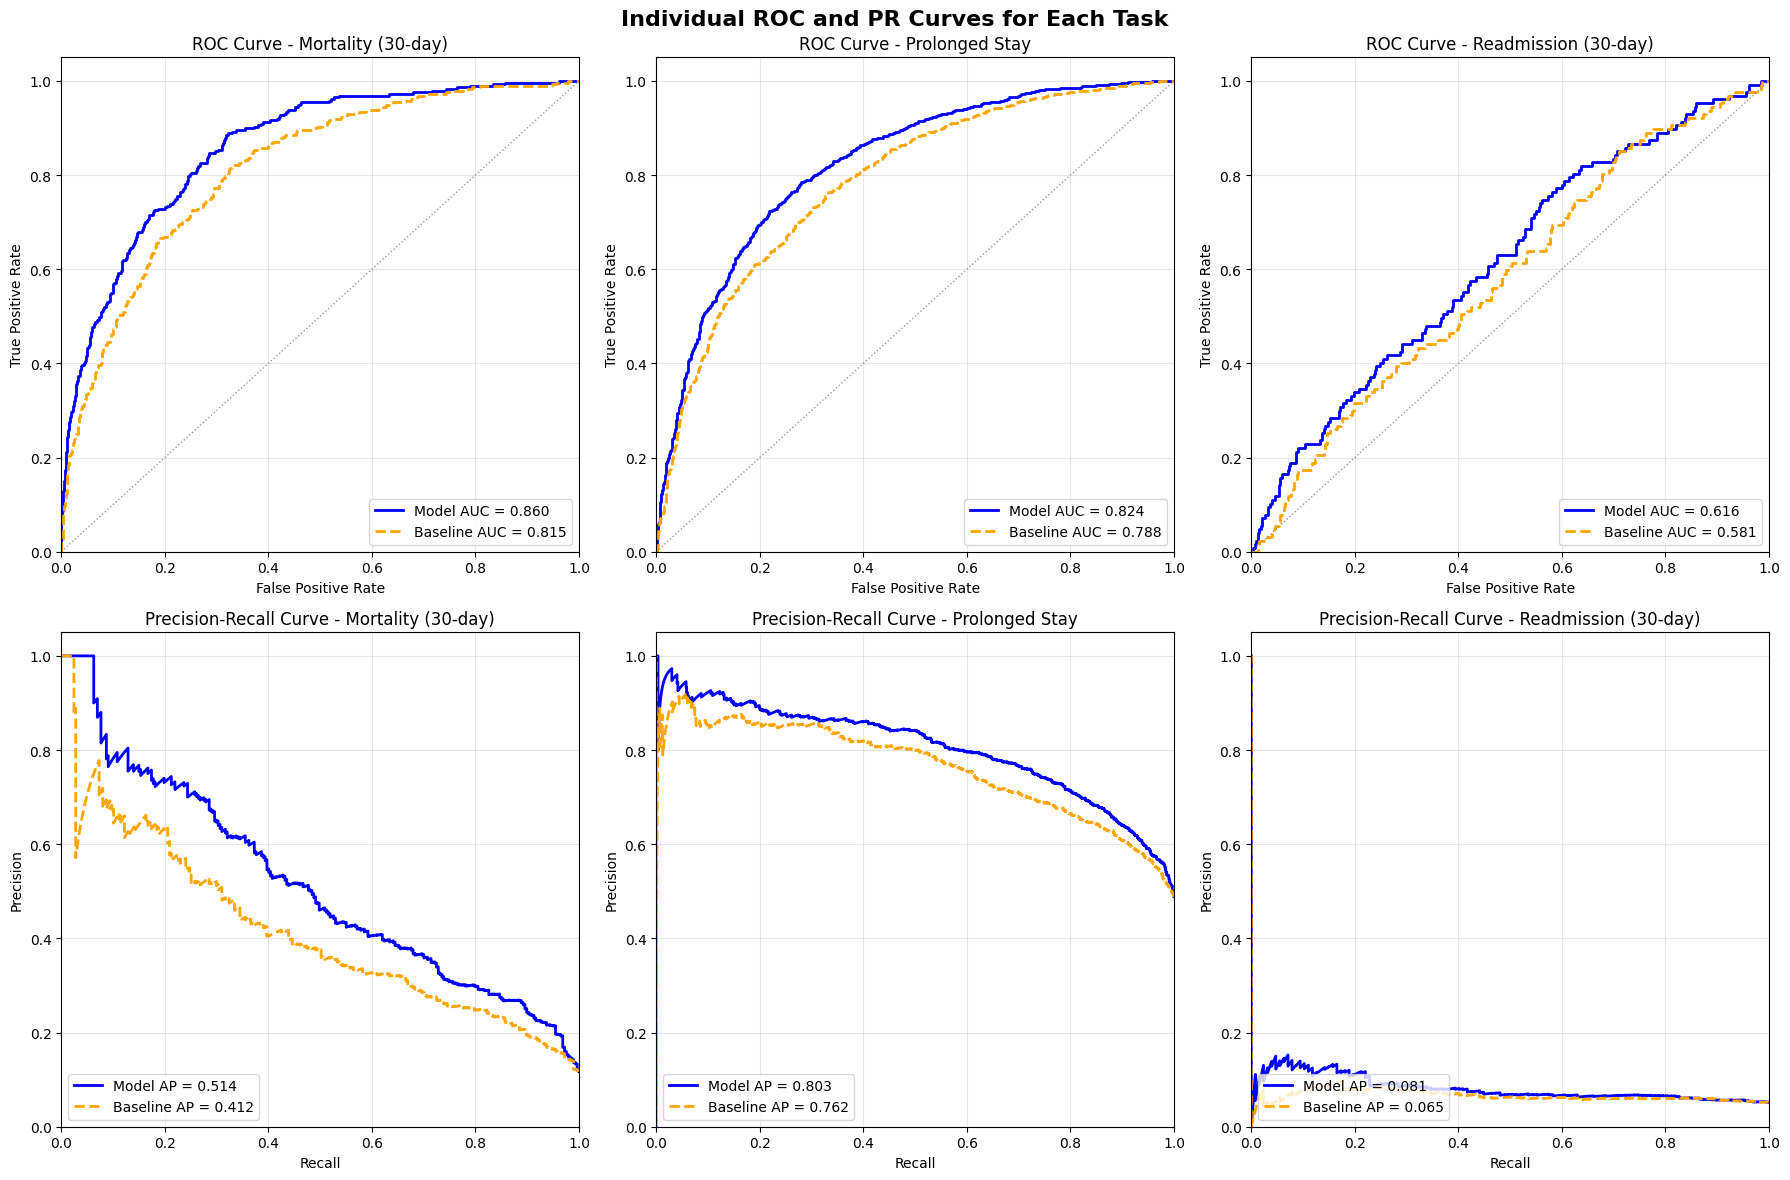


SUMMARY STATISTICS
Task                 Model AUC    Baseline AUC    Model AP     Baseline AP    
------------------------------------------------------------
Mortality (30-day)   0.860        0.815           0.514        0.412          
Prolonged Stay       0.824        0.788           0.803        0.762          
Readmission (30-day) 0.616        0.581           0.081        0.065          


In [9]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, precision_recall_curve, auc

# Additional Analysis: Individual ROC and PR curves for each task
print("Generating predictions on test set...")
y_trues, y_preds = model.validate(dataloaders['test'], datasets['test'], return_predictions=True)

# Define task names for better visualization
task_names = ['Mortality (30-day)', 'Prolonged Stay', 'Readmission (30-day)']

# Convert to numpy arrays for easier handling
for i in range(3):
    y_trues[i] = np.array(y_trues[i])
    y_preds[i] = np.array(y_preds[i])

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Individual ROC and PR Curves for Each Task', fontsize=16, fontweight='bold')

# Colors: model in blue/green/red, baseline in orange
model_colors = 'blue'
baseline_color = 'orange'

# Load baseline model predictions
# Assumes baseline_model is loaded and has a .validate method like the main model
y_trues_baseline, y_preds_baseline = base_model.validate(dataloaders['test'], datasets['test'], return_predictions=True)
for i in range(3):
    y_trues_baseline[i] = np.array(y_trues_baseline[i])
    y_preds_baseline[i] = np.array(y_preds_baseline[i])

for i, task_name in enumerate(task_names):
    # Model
    y_true = y_trues[i]
    y_pred = y_preds[i]
    # Baseline
    y_true_base = y_trues_baseline[i]
    y_pred_base = y_preds_baseline[i]
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    fpr_base, tpr_base, _ = roc_curve(y_true_base, y_pred_base)
    roc_auc_base = auc(fpr_base, tpr_base)
    
    axes[0, i].plot(fpr, tpr, color=model_colors, lw=2, 
                   label=f'Model AUC = {roc_auc:.3f}')
    axes[0, i].plot(fpr_base, tpr_base, color=baseline_color, lw=2, linestyle='--', 
                   label=f'Baseline AUC = {roc_auc_base:.3f}')
    axes[0, i].plot([0, 1], [0, 1], color='gray', lw=1, linestyle=':', alpha=0.8)
    axes[0, i].set_xlim([0.0, 1.0])
    axes[0, i].set_ylim([0.0, 1.05])
    axes[0, i].set_xlabel('False Positive Rate')
    axes[0, i].set_ylabel('True Positive Rate')
    axes[0, i].set_title(f'ROC Curve - {task_name}')
    axes[0, i].legend(loc="lower right")
    axes[0, i].grid(True, alpha=0.3)
    
    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    pr_auc = auc(recall, precision)
    precision_base, recall_base, _ = precision_recall_curve(y_true_base, y_pred_base)
    pr_auc_base = auc(recall_base, precision_base)
    
    axes[1, i].plot(recall, precision, color=model_colors, lw=2, 
                   label=f'Model AP = {pr_auc:.3f}')
    axes[1, i].plot(recall_base, precision_base, color=baseline_color, lw=2, linestyle='--', 
                   label=f'Baseline AP = {pr_auc_base:.3f}')
    axes[1, i].set_xlim([0.0, 1.0])
    axes[1, i].set_ylim([0.0, 1.05])
    axes[1, i].set_xlabel('Recall')
    axes[1, i].set_ylabel('Precision')
    axes[1, i].set_title(f'Precision-Recall Curve - {task_name}')
    axes[1, i].legend(loc="lower left")
    axes[1, i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)
print(f"{'Task':<20} {'Model AUC':<12} {'Baseline AUC':<15} {'Model AP':<12} {'Baseline AP':<15}")
print("-"*60)

for i, task_name in enumerate(task_names):
    # Calculate metrics for model
    fpr, tpr, _ = roc_curve(y_trues[i], y_preds[i])
    roc_auc = auc(fpr, tpr)
    precision, recall, _ = precision_recall_curve(y_trues[i], y_preds[i])
    pr_auc = auc(recall, precision)
    
    # Calculate metrics for baseline
    fpr_base, tpr_base, _ = roc_curve(y_trues_baseline[i], y_preds_baseline[i])
    roc_auc_base = auc(fpr_base, tpr_base)
    precision_base, recall_base, _ = precision_recall_curve(y_trues_baseline[i], y_preds_baseline[i])
    pr_auc_base = auc(recall_base, precision_base)
    
    print(f"{task_name:<20} {roc_auc:<12.3f} {roc_auc_base:<15.3f} {pr_auc:<12.3f} {pr_auc_base:<15.3f}")

print("="*60)

## Bootstraping

In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score
import numpy as np

def bootstrap_eval(res,idx,  n_bootstrap=20, frac=0.2, random_state=42):
    labels = res[0][idx]
    labels = np.array(labels)
    preds = res[1][idx]
    auroc = []
    aupr = []
    for i in range(n_bootstrap):
        idx_bootstrap = np.random.choice(np.arange(len(labels)), size=int(frac*len(labels)), replace=True)
        labels_bootstrap = labels[idx_bootstrap]
        preds_bootstrap = preds[idx_bootstrap]
        auroc.append(roc_auc_score(labels_bootstrap, preds_bootstrap))
        aupr.append(average_precision_score(labels_bootstrap, preds_bootstrap))
    return auroc, aupr


res = model.validate(dataloaders['test'], datasets['test'],return_predictions=True)
aurocs = []
auprs = []
for i in range(3):
    roc, auc = bootstrap_eval(res,i, n_bootstrap=100, frac=0.2, random_state=42)
    aurocs.append(roc)
    auprs.append(auc)

res_base = base_model.validate(dataloaders['test'], datasets['test'],return_predictions=True)
aurocs_base = []
auprs_base = []
for i in range(3):
    roc, auc = bootstrap_eval(res_base,i, n_bootstrap=100, frac=0.2, random_state=42)
    aurocs_base.append(roc)
    auprs_base.append(auc)



In [ ]:
# Change colors: Azure and a light orange
model_color = "#007fff"   # Azure (hex for Azure blue)
base_color = "#ffb347"    # Light orange

fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# AUROC boxplot
positions = np.arange(len(task_names))
box_width = 0.35

for i in range(3):
    axs[0].boxplot(auroc_data[i], positions=[positions[i] - box_width/2], widths=box_width, patch_artist=True,
                   boxprops=dict(facecolor=model_color, color=model_color),
                   medianprops=dict(color='black'),
                   whiskerprops=dict(color=model_color),
                   capprops=dict(color=model_color),
                   flierprops=dict(markerfacecolor=model_color, marker='o', markersize=4, alpha=0.5))
    axs[0].boxplot(auroc_base_data[i], positions=[positions[i] + box_width/2], widths=box_width, patch_artist=True,
                   boxprops=dict(facecolor=base_color, color=base_color),
                   medianprops=dict(color='black'),
                   whiskerprops=dict(color=base_color),
                   capprops=dict(color=base_color),
                   flierprops=dict(markerfacecolor=base_color, marker='o', markersize=4, alpha=0.5))

axs[0].set_xticks(positions)
axs[0].set_xticklabels(task_names)
axs[0].set_ylabel("AUROC")
axs[0].set_title("AUROC (bootstrap)")
# Put the legend outside the figure
axs[0].legend([plt.Line2D([0], [0], color=model_color, lw=8),
               plt.Line2D([0], [0], color=base_color, lw=8)],
              ["Model", "Base Model"], loc="center left", bbox_to_anchor=(1.02, 0.5))

# AUPR boxplot
for i in range(3):
    axs[1].boxplot(aupr_data[i], positions=[positions[i] - box_width/2], widths=box_width, patch_artist=True,
                   boxprops=dict(facecolor=model_color, color=model_color),
                   medianprops=dict(color='black'),
                   whiskerprops=dict(color=model_color),
                   capprops=dict(color=model_color),
                   flierprops=dict(markerfacecolor=model_color, marker='o', markersize=4, alpha=0.5))
    axs[1].boxplot(aupr_base_data[i], positions=[positions[i] + box_width/2], widths=box_width, patch_artist=True,
                   boxprops=dict(facecolor=base_color, color=base_color),
                   medianprops=dict(color='black'),
                   whiskerprops=dict(color=base_color),
                   capprops=dict(color=base_color),
                   flierprops=dict(markerfacecolor=base_color, marker='o', markersize=4, alpha=0.5))

axs[1].set_xticks(positions)
axs[1].set_xticklabels(task_names)
axs[1].set_ylabel("AUPR")
axs[1].set_title("AUPR (bootstrap)")
# Put the legend outside the figure
axs[1].legend([plt.Line2D([0], [0], color=model_color, lw=8),
               plt.Line2D([0], [0], color=base_color, lw=8)],
              ["Model", "Base Model"], loc="center left", bbox_to_anchor=(1.02, 0.5))

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.savefig("auroc_aupr_boxplot.pdf", dpi=300, bbox_inches='tight')


### Calibration Anaylsis

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import calibration_curve


def plot_calibration_curve(y_true, y_prob, n_bins=5, ax=None, hist=True, normalize=False, strategy='quantile'):
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins, strategy=strategy)
    if ax is None:
        ax = plt.gca()
    ax.plot([0, 1], [0, 1], ':', c='k')
    curve = ax.plot(prob_pred, prob_true, marker="o")

    ax.set_xlabel("predicted probability")
    ax.set_ylabel("fraction of positive samples")

    ax.set(aspect='equal')
    return curve


Generating predictions for calibration analysis...
100%|██████████| 20/20 [00:11<00:00,  1.72it/s]


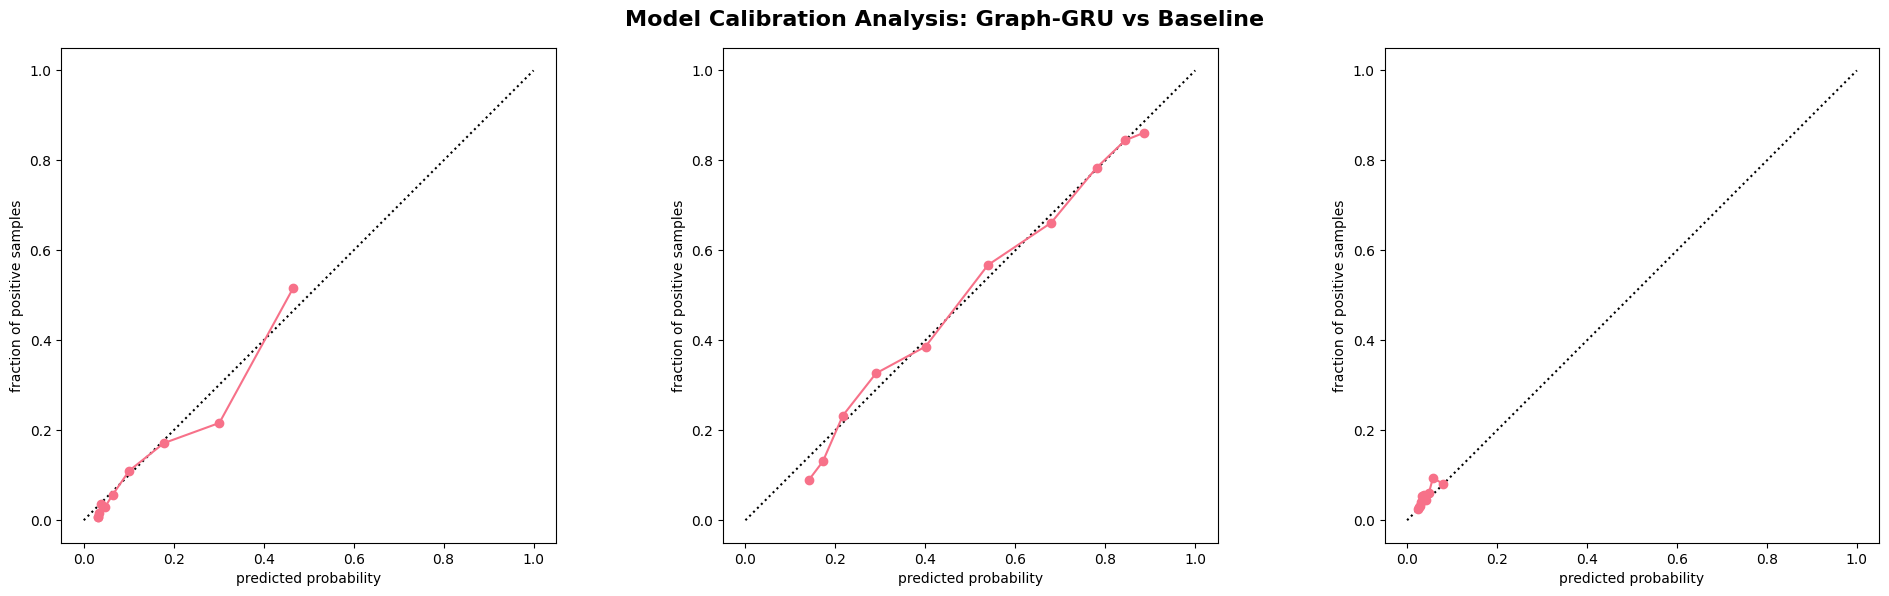

Calibration plots created successfully!


In [27]:
# Generate predictions for calibration analysis
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
print("Generating predictions for calibration analysis...")

# Get predictions from both models
y_trues_model, y_preds_model = model.validate(dataloaders['test'], datasets['test'], return_predictions=True, calibrate=True)

# Convert to numpy arrays
task_names = ['Mortality (30-day)', 'Prolonged Stay', 'Readmission (30-day)']
model_predictions = {}
true_labels = {}

for i, task_name in enumerate(task_names):
    model_predictions[task_name] = np.array(y_preds_model[i])
    true_labels[task_name] = np.array(y_trues_model[i])

plt.style.use('default')
sns.set_palette("husl")

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Model Calibration Analysis: Graph-GRU vs Baseline', fontsize=16, fontweight='bold')

for i, task_name in enumerate(task_names):
    ax_model = axes[i]
    strategy = 'quantile' if i == 2 else 'uniform'
    plot_calibration_curve(true_labels[task_name], model_predictions[task_name], 
                          ax=ax_model, n_bins=10)
plt.tight_layout()
plt.savefig('calibration_plot.png')
plt.show()

print("Calibration plots created successfully!")


## Ablation results

In [31]:
import json
from ablation_study import compare_ablation_results

with open('ablation_results.json', 'r') as f:
    ablation_results = json.load(f)

compare_ablation_results(ablation_results)



ABLATION STUDY RESULTS COMPARISON
Configuration        Mortality AP LOS AP       Readmission AP 
--------------------------------------------------------------------------------
all_modalities       0.5114       0.8053       0.0852         

DETAILED RESULTS

ALL_MODALITIES:
Description: All modalities (baseline)
Modalities: {'use_notes': True, 'use_bios': True, 'use_prescriptions': True, 'use_x': True, 'description': 'All modalities (baseline)'}
Test Results:
  Mortality - AUC: 0.8604 | AP: 0.5114
  Prolonged LOS - AUC: 0.8268 | AP: 0.8053
  Readmission - AUC: 0.5999 | AP: 0.0852


<!-- 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]
Test Mortality: AUC-ROC: 0.85  AP: 0.52
Test Prolonged Stay: AUC-ROC: 0.82  AP: 0.80
Test Readmission: AUC-ROC: 0.62  AP: 0.08 -->

<!-- Test Mortality: AUC-ROC: 0.87  AP: 0.52
Test Prolonged Stay: AUC-ROC: 0.83  AP: 0.81
Test Readmission: AUC-ROC: 0.62  AP: 0.08 -->